![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* analyse first-order (main effects) and total-order (total effects) indices of Sobol' using NSE as objective function
* analyse convergence of Sobol' indices
* assess Sobol' indices for multiple objective functions
* use the PAWN method

- - - 

# 4 d - Sensitivity analysis - Sobol and PAWN

- - -

## 1 Introduction

### 1.1 Sobol Indices

The Sobol method is a variance-based global sensitivity analysis technique that quantifies how much of the output variance of a model can be attributed to individual input parameter or combinations of them.

What do we mean by this? We fix a set of parameters and compare how the variance in the output objective drops compared to the case in which all parameters are varied freely. When the variance drops significantly, then the parameter is having a high contribution to the overall variance and the parameter is considered important.

We can then further discriminate three different effects:
* First-order effects: The variance contribution of each parameter considered independently (i.e. when only one parameter is fixed at a time).
* Higher-order effects: Contributions from interactions between two or more parameter (i.e. when a combination of parameters is fixed).
* Total effects: The sum of all effects of one parameter (i.e. all combinations that include one parameter are fixed).

By definition, the total effects are always larger than the direct effects, as they include this term. All effects should sum to one, as all parameter combinations together should explain the full variance.

The Sobol method is highly interpretable and widely applicable but can be computationally expensive due to its reliance on numerous model evaluations to estimate the variance components accurately.

### 1.2 PAWN
The Sobol indices are entirely based on the first moment (the variance) of the objective probability distribution. They become unusable when the distribution is highly skewed, has multiple modes or unstable variance.

The PAWN method provides an alternative approach to define sensitivity indices. Instead of focusing on variance, PAWN examines how the probability distribution of the model output changes when an input parameter is fixed at different values within its range. It is based on comparing the cumulative distribution function (CDF) of the case in which all parameters are varied with conditional CDFs for which only a set of parameters are varied. The CDFs are compared in terms of the Kolmogorov–Smirnov statistic which represents the largest maximum difference between curves.

PAWN is generally less computationally intensive than Sobol and is particularly useful for models with non-linear and non-additive behaviors.

- - -

## 2 Using Sobol and PAWN

**Set current working directory and import python modules**

In [1]:
import sys
sys.path.append('src/')
import HBV, VBSA, PAWN, EET
import plot_functions as pf # module to visualize the results
from sampling import AAT_sampling, AAT_sampling_extend # functions to perform the input sampling
from util import aggregate_boot # function to aggregate the bootstrap results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import logging
logger = logging.getLogger("numba")
logger.setLevel(logging.ERROR)
from ipywidgets import interact, Dropdown
from matplotlib.patches import Rectangle

# overwrite colors
plt.style.use('default')
plt.matplotlib.cm.jet = lambda _: [(0.902, 0.098, 0.294), (0.235, 0.706, 0.294), (0.263, 0.388, 0.847), (0.961, 0.510, 0.192), (0.667, 1.000, 0.765), (0.259, 0.831, 0.957), (0.663, 0.663, 0.663), (1.000, 0.882, 0.098), (0.941, 0.196, 0.902), (0.980, 0.745, 0.831), (0.275, 0.600, 0.565), (0.604, 0.388, 0.141), (0.863, 0.745, 1.000)]


def calc_nse(obs, sim):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) for model evaluation.
    The NSE ranges from zero to one, with one being optimal.
    """
    r_nse = np.corrcoef(obs, sim)[0][1] 
    alpha_nse = np.divide(np.std(sim), np.std(obs))
    beta_nse = np.divide(np.subtract(np.mean(sim), np.mean(obs)), np.std(obs))
    nse = 2 * alpha_nse * r_nse - np.square(alpha_nse) - np.square(beta_nse)
    return nse

def calc_rmse(obs, sim):
    """
    Calculate the Root Mean Square Error (RMSE) between observed and simulated values.
    The RMSE ranges from zero to infinity.
    """
    return np.sqrt(np.mean((obs - sim)**2))

def calc_bias(obs, sim):
    """
    Compute the mean bias (mean difference) between observed and simulated values.
    """
    return np.mean(np.subtract(obs, sim))

def calc_corr(obs, sim):
    """
    Calculate the correlation Pearson coefficient between observed and simulated values.
    """
    return np.corrcoef(obs, sim)[0,1]

def hbv(par, precip, temp, evap):
    """
    Run the HBV model to simulate runoff based on precipitation and temperature.
    """
    p_s, _, _ = HBV.snow_routine(par[:4], temp, precip)
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(par[4:], p_s, evap, Case, ini)
    return runoff_sim

def hbv_and_one_obj_fun(par, precip, temp, evap, runoff_obs, n_days, obj_fun):
    """
    Simulate runoff using HBV and evaluate with a single objective function.
    """
    runoff_sim = hbv(par, precip, temp, evap)
    errors = obj_fun(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

def hbv_and_three_obj_fun(par, precip, temp, evap, runoff_obs, n_days, obj_fun1, obj_fun2, obj_fun3):
    """
    Simulate runoff using HBV and evaluate with three objective functions.
    """
    runoff_sim = hbv(par, precip, temp, evap)
    errors = np.nan * np.ones((3,))
    errors[0] = obj_fun1(runoff_obs[n_days:], runoff_sim[n_days:])
    errors[1] = obj_fun2(runoff_obs[n_days:], runoff_sim[n_days:])
    errors[2] = obj_fun3(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

def load_catchment_data(file, startDate="2000", endDate="2005"):
    data = pd.read_csv(file, sep=r"\s+")
    # combine columns to create a datetime column
    data['DATE'] = pd.to_datetime(data[['YR', 'MNTH', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
    # set the new column as the index
    data = data.set_index('DATE')
    # keep only relevant variables
    data = data[["PRCP", "TAIR", "PET", "SWE", "OBS_RUN"]]
    # rename the columns
    data.columns = ["P", "T", "PET", "Snow", "Q_obs"]

    # subset range
    data = data.loc[(data.index >= startDate) & (data.index <= endDate)]
    return data

def sort_legend_by(order, **kwargs):

    # grab the legend handles and labels
    handles = plt.gca().legend_.legend_handles
    labels  = [label._text for label in plt.gca().legend_.texts]

    # sort both handles and labels
    handles = np.array(handles)[order]
    labels  = np.array(labels)[order]

    # set the handles of the legend
    plt.gca().legend(handles, labels, **kwargs)

plt.sort_legend_by = sort_legend_by

**Read Catchment File, Define Parameter Bounds**

In [2]:
dict_catchments = {
    "Medina River, TX, USA": "./data/08178880_medina_TX.txt",
    "Siltez River, OR, USA": "./data/14305500_siletz_OR.txt",
    "Dix River, KY, USA": "./data/03285000_dix_KY.txt",
    "Knife River, MN, USA": "./data/04015330_knife_MN.txt"
}
catchment_dropdown = Dropdown(options=dict_catchments.items(), index=2)
display(catchment_dropdown)

Dropdown(index=2, options=(('Medina River, TX, USA', './data/08178880_medina_TX.txt'), ('Siltez River, OR, USA…

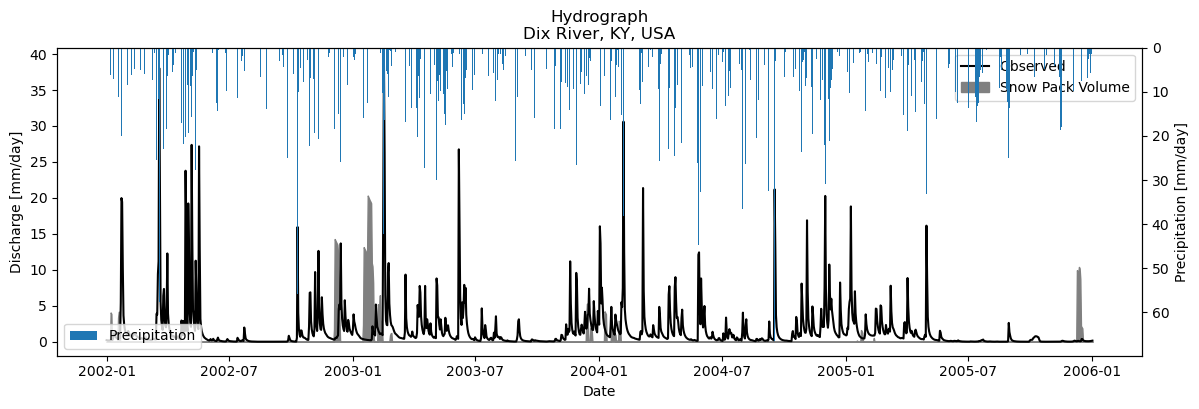

In [30]:
# load the catchment data
df = load_catchment_data(catchment_dropdown.value, '2002', '2006')
P, PET, T, Q_obs = df[['P', 'PET', 'T', 'Q_obs']].values.T

# number of spinup days before the evaluation period
n_spinup_days = 365

# define parameter names and bounds
parameter_names = ["Ts"  , "CFMAX", "CFR", "CWH", "BETA", "LP", "FC", "PERC", "K0", "K1", "K2" , "UZL", "MAXBAS"]
lower           = np.array([-2.5  , 0.5    , 0    , 0    , 0     , 0.3 , 50  , 0     , 0.05, 0.01, 0.001, 0    , 1])
upper           = np.array([ 2.5  , 5      , 0.1  , 0.2  , 6     , 5   , 700 , 60    , 0.99, 0.8 , 0.15 , 250  , 3])
ranges          = np.stack([lower, upper], axis=1)
n_parameters    = len(parameter_names)

plt.figure(figsize=(14, 4))
plt.plot(df.index, Q_obs, color="black", label="Observed")
plt.fill_between(df.index, 0, df.Snow, color="gray", label="Snow Pack Volume", zorder=0)
plt.xlabel("Date")
plt.ylabel("Discharge [mm/day]")
plt.legend()
plt.twinx()
plt.bar(df.index, P, label="Precipitation", color="C0", linestyle="--")
plt.gca().invert_yaxis()
plt.ylabel("Precipitation [mm/day]")
plt.legend()
plt.title("Hydrograph\n" + list(dict_catchments.keys())[catchment_dropdown.index])
plt.show()

# snow using fillbetween

- - -

### 2.1 Using the Sobol method

#### 2.1.1 Analysing main effects, total effects and interactions

**Get samples**

In [31]:
# define distribution
distr_fun = st.uniform # uniform distribution
distr_par = [np.nan] * n_parameters
for i in range(n_parameters):
    distr_par[i] = [lower[i], upper[i] - lower[i]]
    
sampling_strategy = "lhs" # define the sampling strategy
n_samples = 500 #  Number of samples. For the tutorial we use 250, but you should rather use well over 1000 samples.

parameter_sets = AAT_sampling(sampling_strategy, n_parameters, distr_fun, distr_par, 2*n_samples)
parameter_sets_A, parameter_sets_B, parameter_sets_C = VBSA.vbsa_resampling(parameter_sets)

**Run the model and compute selected model output at sampled parameter sets**

In [32]:
print("Executing models (1/3): this might take a while")
errors_A = np.nan * np.ones(parameter_sets_A.shape[0]) 
for i, parameter_set_A in enumerate(parameter_sets_A):
    errors_A[i], _ = hbv_and_one_obj_fun(parameter_set_A, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Executing models (2/3): hang on")
errors_B = np.nan * np.ones(parameter_sets_B.shape[0]) 
for i, parameter_set_B in enumerate(parameter_sets_B):
    errors_B[i], _ = hbv_and_one_obj_fun(parameter_set_B, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Executing models (3/3): almost done")
errors_C = np.nan * np.ones(parameter_sets_C.shape[0]) 
for i, parameter_set_C in enumerate(parameter_sets_C):
    errors_C[i], _ = hbv_and_one_obj_fun(parameter_set_C, P, T, PET, Q_obs, n_spinup_days, calc_nse)
print("Computing main (first-order) and total effects")
sobol_main, sobol_total = VBSA.vbsa_indices(errors_A, errors_B, errors_C, n_parameters)

Executing models (1/3): this might take a while
Executing models (2/3): hang on
Executing models (3/3): almost done
Computing main (first-order) and total effects


**Use bootstrapping to derive confidence bounds**

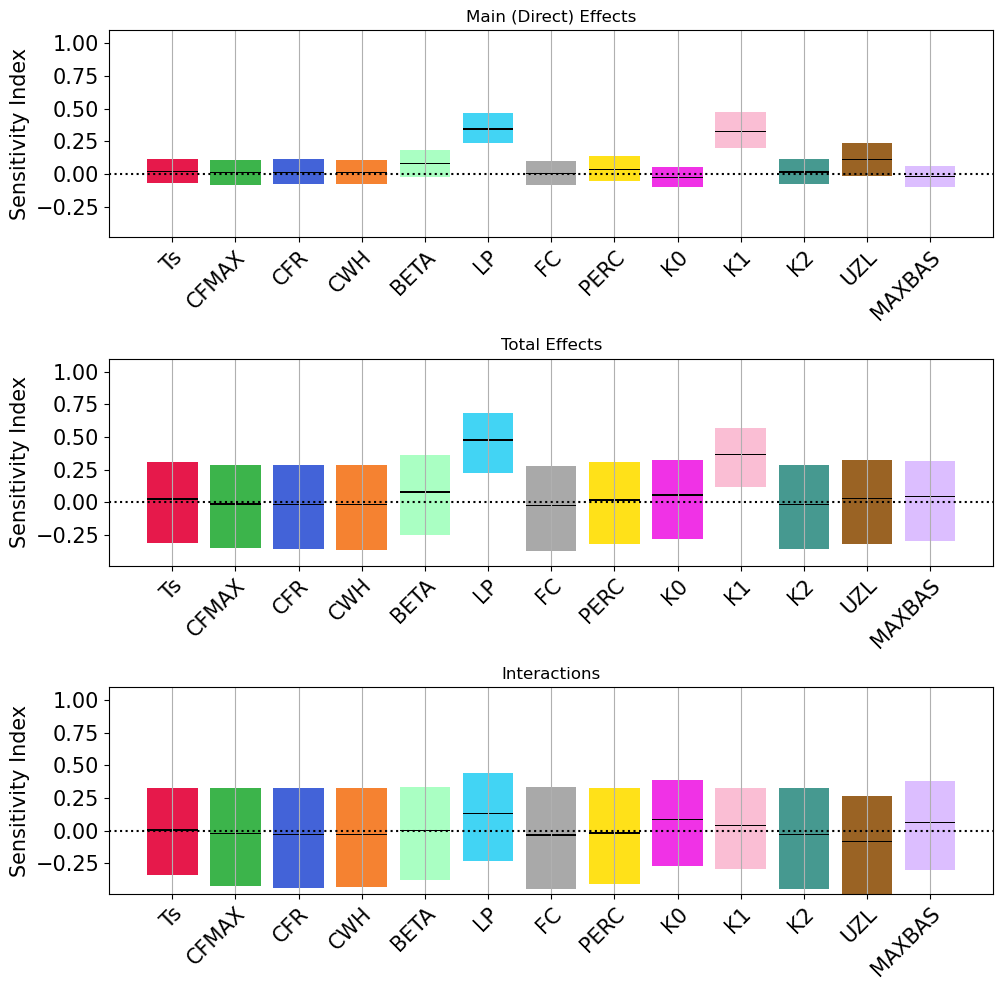

In [33]:
n_boot = 500  # bootstrap resample number
sobol_main_boot, sobol_total_boot = VBSA.vbsa_indices(errors_A, errors_B, errors_C, n_parameters, Nboot=n_boot)  # Compute sensitivity indices; each with shape (n_boot, n_parameters)
# Computing mean and confidence intervals of the sensitivity indices across the bootstrap resamples
sobol_main_m, sobol_main_lb, sobol_main_ub = aggregate_boot(sobol_main_boot) # shape (n_parameters,)
sobol_total_m, sobol_total_lb, sobol_total_ub = aggregate_boot(sobol_total_boot) # shape (n_parameters,)
sobol_inter_m, sobol_inter_lb, sobol_inter_ub = aggregate_boot(sobol_total_boot-sobol_main_boot) # shape (n_parameters,)

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

plt.sca(axs[0])
plt.title("Main (Direct) Effects")
pf.boxplot1(sobol_main_m, S_lb=sobol_main_lb, S_ub=sobol_main_ub, X_Labels=parameter_names, Y_Label='Sensitivity Index')

plt.sca(axs[1])
plt.title("Total Effects")
pf.boxplot1(sobol_total_m, S_lb=sobol_total_lb, S_ub=sobol_total_ub, X_Labels=parameter_names, Y_Label='Sensitivity Index')

plt.sca(axs[2])
plt.title("Interactions")
pf.boxplot1(sobol_inter_m, S_lb=sobol_inter_lb, S_ub=sobol_inter_ub, X_Labels=parameter_names, Y_Label='Sensitivity Index')

for ax in axs:
    ax.set_xticklabels(parameter_names, rotation=45, ha='right', rotation_mode='anchor')
    for child in ax._children:
        if isinstance(child, Rectangle):
            child.set(edgecolor="none")


plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task I: Understanding the Sobol Method</h4>
    Above you will find the direct and total Sobol indices as well as their interactions for the 13 paramters of the HBV model.
    <ol>
        <li>Which parameters has the highest direct (total, interaction) effect?</li>
        <li>Consider the confidence bounds. Were do you need to be careful with your interpretation?</li>
        <li>Are these results similar to your findings from the last tutorial?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
</div>

#### 2.1.3 Increasing the sample size

**Resample with extended sample size**

In [34]:
n_samples_new = 500 # increase of base sample size
# (that means: n_samples_new*(n_parameters+2) new samples that will need to be evaluated)
parameter_sets_extended = AAT_sampling_extend(parameter_sets, distr_fun, distr_par, 2*(n_samples+n_samples_new)) # extended sample
# (it includes the already evaluated samples and the new ones)
parameter_sets_new = parameter_sets_extended[2*n_samples:2*(n_samples+n_samples_new), :] # extract the new input samples that need to be evaluated

# Resampling strategy:
print("Resampling using extended set of samples")
[parameter_sets_A_new, parameter_sets_B_new, parameter_sets_C_new] = VBSA.vbsa_resampling(parameter_sets_new)
# Evaluate model against new samples:
print("Executing models (1/3): this might take a while")
errors_A_new = np.nan * np.ones(parameter_sets_A_new.shape[0]) 
for i, parameter_set_A_new in enumerate(parameter_sets_A_new):
    errors_A_new[i], _ = hbv_and_one_obj_fun(parameter_set_A_new, P, T, PET, Q_obs, n_spinup_days, calc_nse)
# should have shape (n_samples_new, 1)
print("Executing models (2/3): wait")
errors_B_new = np.nan * np.ones(parameter_sets_B_new.shape[0]) 
for i, parameter_set_B_new in enumerate(parameter_sets_B_new):
    errors_B_new[i], _ = hbv_and_one_obj_fun(parameter_set_B_new, P, T, PET, Q_obs, n_spinup_days, calc_nse)
# should have shape (n_samples_new, 1)
print("Executing models (3/3): almost done")
errors_C_new = np.nan * np.ones(parameter_sets_C_new.shape[0]) 
for i, parameter_set_C_new in enumerate(parameter_sets_C_new):
    errors_C_new[i], _ = hbv_and_one_obj_fun(parameter_set_C_new, P, T, PET, Q_obs, n_spinup_days, calc_nse)
# should have shape (n_samples_new*n_parameters, 1)

print("Combining new and old results")
errors_A_2 = np.concatenate((errors_A, errors_A_new))  # should have shape (n_samples+n_samples_new, 1)
errors_B_2 = np.concatenate((errors_B, errors_B_new))  # should have shape (n_samples+n_samples_new,1)
errors_C_2 = np.concatenate((np.reshape(errors_C, (n_parameters, n_samples)), np.reshape(errors_C_new, (n_parameters, n_samples_new))),
                             axis=1)# should have size (n_parameters, n_samples+n_samples_new)
errors_C_2 = errors_C_2.flatten() # should have size ((n_samples+n_samples_new)*n_parameters, )

print("Recomputing indices with bootstrap")
n_boot = 1000
sobol_main_2, sobol_total_2 = VBSA.vbsa_indices(errors_A_2, errors_B_2, errors_C_2, n_parameters, n_boot)

print("Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples")
sobol_main_2_m, sobol_main_2_lb, sobol_main_2_ub = aggregate_boot(sobol_main_2) # shape (n_parameters,)
sobol_total_2_m, sobol_total_2_lb, sobol_total_2_ub = aggregate_boot(sobol_total_2) # shape (n_parameters,)

Resampling using extended set of samples
Executing models (1/3): this might take a while
Executing models (2/3): wait
Executing models (3/3): almost done
Combining new and old results
Recomputing indices with bootstrap
Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples


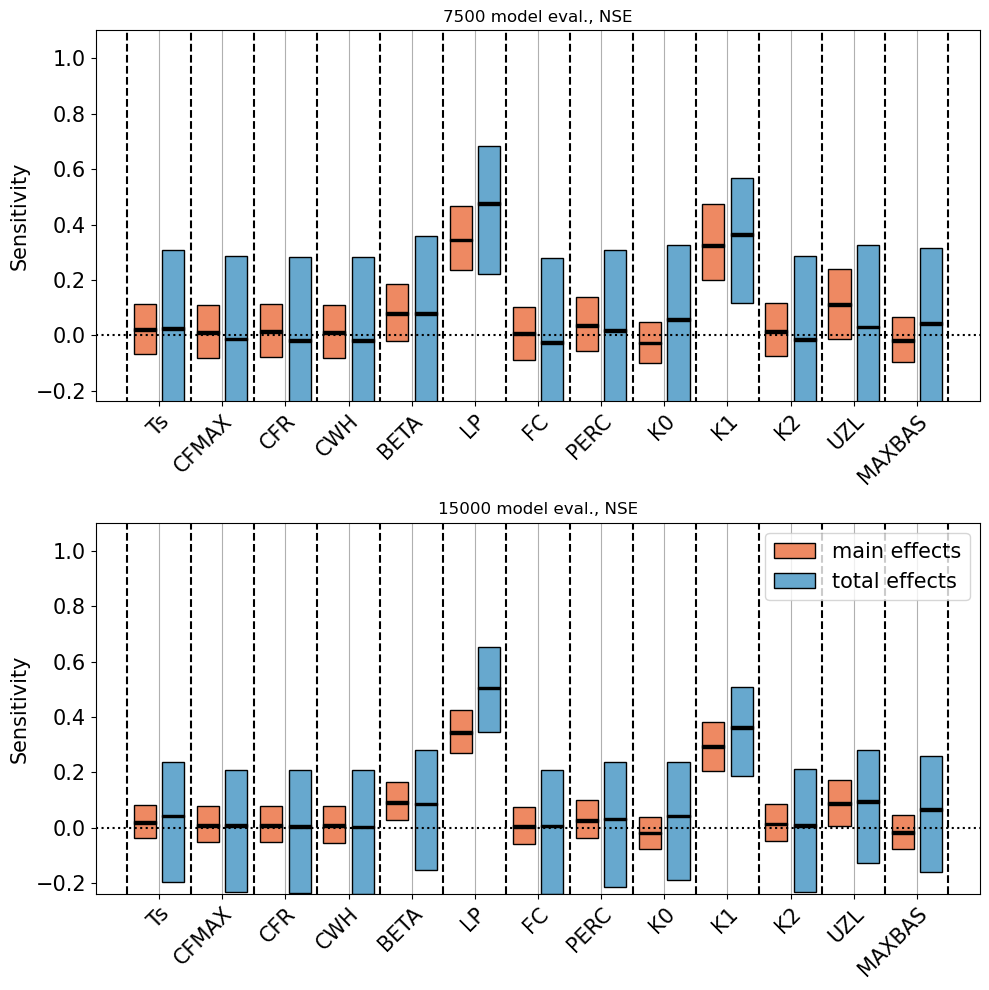

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

plt.sca(axs[0])
pf.boxplot2(np.stack((sobol_main_m, sobol_total_m)), S_lb=np.stack((sobol_main_lb, sobol_total_lb)),
            S_ub=np.stack((sobol_main_ub, sobol_total_ub)), X_Labels=parameter_names)
plt.title('%d' % (n_samples*(n_parameters+2)) + ' model eval., NSE')

plt.sca(axs[1])
pf.boxplot2(np.stack((sobol_main_2_m, sobol_total_2_m)), S_lb=np.stack((sobol_main_2_lb, sobol_total_2_lb)),
            S_ub=np.stack((sobol_main_2_ub, sobol_total_2_ub)), X_Labels=parameter_names,
            legend=['main effects', 'total effects'])
plt.title('%d' % ((n_samples+n_samples_new)*(n_parameters+2)) + ' model eval., NSE')

for ax in axs:
    ax.set_xticklabels(parameter_names, rotation=45, ha='right', rotation_mode='anchor')

plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task II: Increased Sample Size</h4>
    Above you find the direct (red) and total (blue) Sobol indices for two different numbers of model runs. The plot is sadly not colored by parameters, as this funcionality is not provided by the implementation.
    <ul>
        <li>In what ways do the results change between the different sample sizes?</li>
    </ul>
</div>

_DOUBLE CLICK TO ANSWER HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
</div>

#### 2.1.4 Sobol with multiple objective functions 

**Using multiple objective functions (RMSE, bias, correlation)**

In [10]:
print("Executing models (1/3): this might take a while")
errors_A_mulobj = np.nan * np.ones((parameter_sets_A.shape[0], 3))
for i, parameter_set_A in enumerate(parameter_sets_A):
    (errors_A_mulobj[i,0], errors_A_mulobj[i,1], errors_A_mulobj[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set_A, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)
print("Executing models (2/3): wait")
errors_B_mulobj = np.nan * np.ones((parameter_sets_B.shape[0], 3))
for i, parameter_set_B in enumerate(parameter_sets_B):
    (errors_B_mulobj[i,0], errors_B_mulobj[i,1], errors_B_mulobj[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set_B, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)
print("Executing models (3/3): almost done")
errors_C_mulobj = np.nan * np.ones((parameter_sets_C.shape[0], 3)) 
for i, parameter_set_C in enumerate(parameter_sets_C):
    (errors_C_mulobj[i,0], errors_C_mulobj[i,1], errors_C_mulobj[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set_C, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)

print("Computing sensitivity indices")
n_boot = 1000
sobol_main_1, sobol_total_1 = VBSA.vbsa_indices(errors_A_mulobj[:, 0], errors_B_mulobj[:, 0], errors_C_mulobj[:, 0], n_parameters, n_boot)
sobol_main_2, sobol_total_2 = VBSA.vbsa_indices(errors_A_mulobj[:, 1], errors_B_mulobj[:, 1], errors_C_mulobj[:, 1], n_parameters, n_boot)
sobol_main_3, sobol_total_3 = VBSA.vbsa_indices(errors_A_mulobj[:, 2], errors_B_mulobj[:, 2], errors_C_mulobj[:, 2], n_parameters, n_boot)

print("Computing mean and confidence intervals of the sensitivity indices across the bootstrap resamples")
sobol_main_1_m, sobol_main_1_lb, sobol_main_1_ub = aggregate_boot(sobol_main_1) # shape (n_parameters, )
sobol_total_1_m, sobol_total_1_lb, sobol_total_1_ub = aggregate_boot(sobol_total_1) # shape (n_parameters, )
sobol_main_2_m, sobol_main_2_lb, sobol_main_2_ub = aggregate_boot(sobol_main_2) # shape (n_parameters, )
sobol_total_2_m, sobol_total_2_lb, sobol_total_2_ub = aggregate_boot(sobol_total_2) # shape (n_parameters, )
sobol_main_3_m, sobol_main_3_lb, sobol_main_3_ub = aggregate_boot(sobol_main_3) # shape (n_parameters, )
sobol_total_3_m, sobol_total_3_lb, sobol_total_3_ub = aggregate_boot(sobol_total_3) # shape (n_parameters, )

Executing models (1/3): this might take a while
Executing models (2/3): wait
Executing models (3/3): almost done
Computing sensitivity indices
Computing mean and confidence intervals of the sensitivity indices across the bootstrap resamples


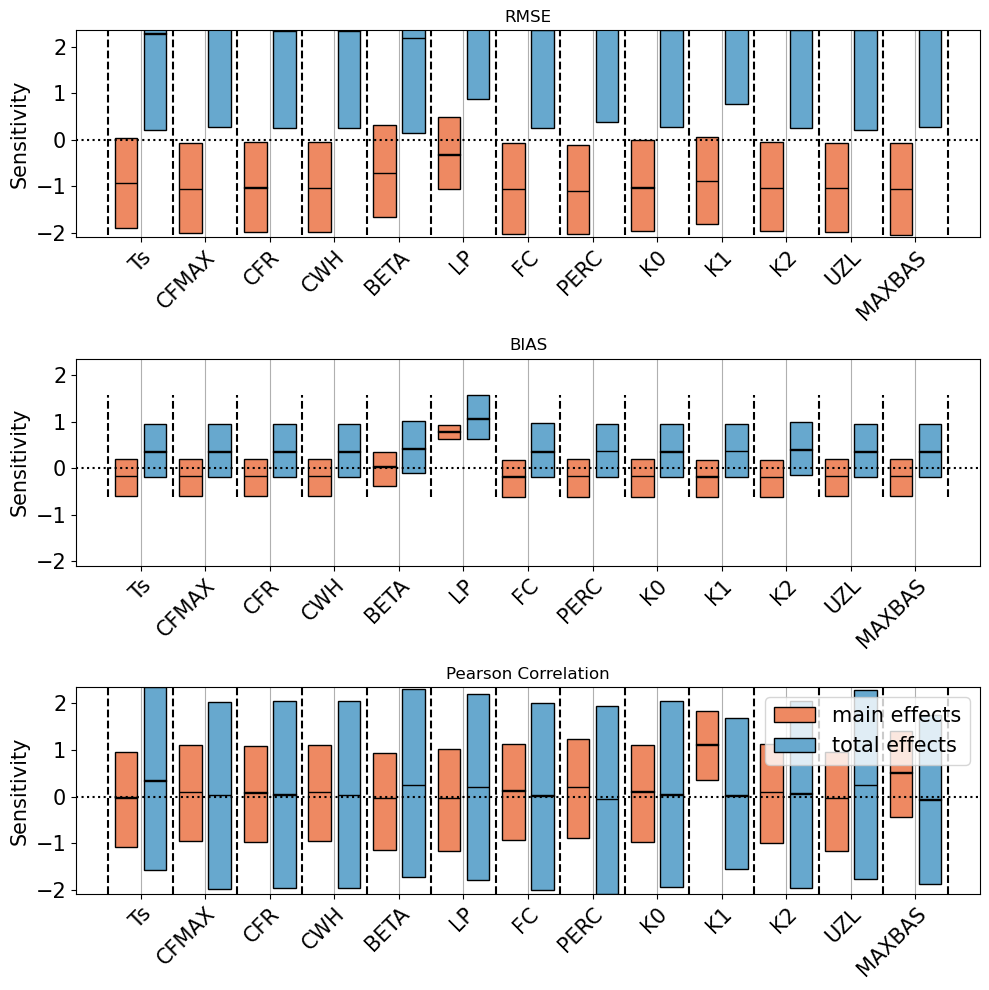

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

plt.sca(axs[0])
pf.boxplot2(np.stack((sobol_main_1_m, sobol_total_1_m)), S_lb=np.stack((sobol_main_1_lb, sobol_total_1_lb)),
            S_ub=np.stack((sobol_main_1_ub, sobol_total_1_ub)), X_Labels=parameter_names)
plt.title('RMSE')

plt.sca(axs[1])
pf.boxplot2(np.stack((sobol_main_2_m, sobol_total_2_m)), S_lb=np.stack((sobol_main_2_lb, sobol_total_2_lb)),
            S_ub=np.stack((sobol_main_2_ub, sobol_total_2_ub)), X_Labels=parameter_names)
plt.title('BIAS')

plt.sca(axs[2])
pf.boxplot2(np.stack((sobol_main_3_m, sobol_total_3_m)), S_lb=np.stack((sobol_main_3_lb, sobol_total_3_lb)),
            S_ub=np.stack((sobol_main_3_ub, sobol_total_3_ub)), X_Labels=parameter_names,
            legend=['main effects', 'total effects'])
plt.title('Pearson Correlation')

for ax in axs:
    ax.set_xticklabels(parameter_names, rotation=45, ha='right', rotation_mode='anchor')

plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task III: Comparing Objective Functions</h4>
    Above you find the direct and total sensitivity indices now derived for three different objective functions (RMSE, Bias and Pearson Correlation).
    <ul>
    <li>Can you spot any differences between the three metrics?</li>
    <li>Does the most important parameter change between metrics?</li>
    </ul>
</div>

_DOUBLE CLICK TO ANSWER HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
</div>

### 2.2 PAWN

**Using multiple objective functions (RMSE, bias, correlation) for PAWN**

In [12]:
n_pawn = 10

print("Executing models: this might take a while")
errors_pawn = np.nan * np.ones((parameter_sets.shape[0], 3))
for i, parameter_set in enumerate(parameter_sets):
    (errors_pawn[i,0], errors_pawn[i,1], errors_pawn[i,2]), _ = \
        hbv_and_three_obj_fun(parameter_set, P, T, PET, Q_obs, n_spinup_days, calc_rmse, calc_bias, calc_corr)

print("Computing PAWN sensitivity indices")
KS_rmse_median, KS_rmse_mean, KS_rmse_max = PAWN.pawn_indices(parameter_sets, errors_pawn[:,0], n_pawn)
KS_bias_median, KS_bias_mean, KS_bias_max = PAWN.pawn_indices(parameter_sets, errors_pawn[:,1], n_pawn)
KS_corr_median, KS_corr_mean, KS_corr_max = PAWN.pawn_indices(parameter_sets, errors_pawn[:,2], n_pawn)

Executing models: this might take a while
Computing PAWN sensitivity indices


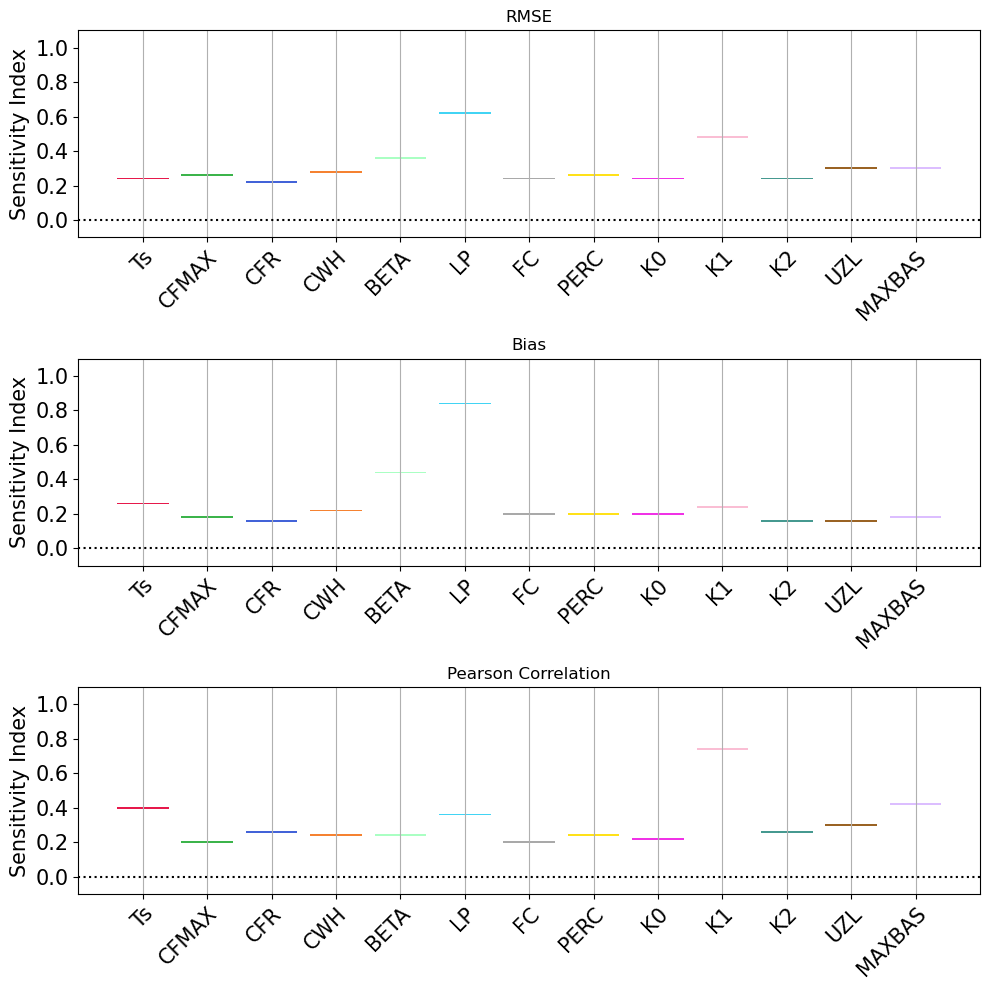

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

plt.sca(axs[0])
pf.boxplot1(KS_rmse_max, X_Labels=parameter_names)
plt.title('RMSE')

plt.sca(axs[1])
pf.boxplot1(KS_bias_max, X_Labels=parameter_names)
plt.title('Bias')

plt.sca(axs[2])
pf.boxplot1(KS_corr_max, X_Labels=parameter_names)
plt.title('Pearson Correlation')

for ax in axs:
    ax.set_ylabel("Sensitivity Index")
    ax.set_xticklabels(parameter_names, rotation=45, ha='right', rotation_mode='anchor')
    for child in ax._children:
        if isinstance(child, Rectangle):
            child.set(edgecolor="none")

plt.tight_layout()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task IV: PAWN</h4>
    We now use the same three objective functions with the PAWN method for sensitivity analysis.
    <ul>
    <li>Are there differences in the rankings of the paramters between Sobol and PAWN?</li>
    </ul>
</div>

_DOUBLE CLICK TO ANSWER HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
</div>